In [144]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import copy
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from collections import defaultdict
from torch.utils.data import TensorDataset, DataLoader

In [2]:
bkdatafolder = "/Volumes/T7 Touch/TheseProject/DR_KELLA/BKDataCleaned/"
dataset_name = os.listdir(bkdatafolder)

In [3]:
def createDictFloor(floor_name):
    getdict = {}
    floors = [floor for floor in dataset_name if floor_name in floor]
    for name in floors:
        floorname = name.split(".")[0]
        getdict[floorname] = pd.read_csv(bkdatafolder+name, index_col=0, parse_dates=["Date"])
        getdict[floorname] = getdict[floorname].sort_index()
    return getdict

def Missing_values(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total,percent], axis=1, keys=['Total', 'Pourcentage'])
    print (missing_data[(percent>0)],'\n' )

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
def createPlot(date1, date2, features, data):
    for floor in data.keys():
        data[floor].resample("5T").mean()[features][date1:date2].plot(figsize=(20,7))
        

def createDTFeat(date1, date2, datadict, features, resample_method="sum" ,scale=True):
    resample_move = {}
    index_nan = {}
    index_small = {}
    floors = list(datadict.keys())
    dates = []
    scalers = {}
    for data in datadict.keys():
        if resample_method == "sum":
            resample_move[data] = floor_dict[data][date1:date2].resample(
                "5min").sum()
            
        elif resample_method == "max":
            resample_move[data] = floor_dict[data][date1:date2].resample(
                "5min").max().bfill()
        elif resample_method == "mean":
            resample_move[data] = floor_dict[data][date1:date2].resample(
                "5min").mean().bfill()
            
        cols = resample_move[data].columns
        idx = resample_move[data].index

        if scale:
            scaler = MinMaxScaler()
            scaler.fit(resample_move[data])
            resample_move[data] = pd.DataFrame(scaler.transform(
                resample_move[data]),
                                               columns=cols,
                                               index=idx)
            scalers[data] = scaler

        resample_move[data]["weekday"] = resample_move[data].index.day_name()
        resample_move[data]["date"] = resample_move[data].index.date
        resample_move[data]["time"] = resample_move[data].index.time

        nan = np.where(pd.isnull(resample_move[data][features]))[0]
        index_nan[data] = np.unique(resample_move[data].iloc[nan]["time"])

    return resample_move, scalers, index_nan

def getInfoTimeShape(datadict):
    for floor in datadict.keys():
        data = datadict[floor]
        print("Floor : {} , shape :{} , TimeMin {} , TimeMax {}".format(floor,data.shape, data.index.min(), data.index.max()))
        Missing_values(data)
        
def cleanNan(data,idx_nan):
    index=[]
    for k,v in idx_nan.items():
        for ele in v:
            index.append(ele)
    mynan = set(index)
    newdata = data.copy()
    remain_date = []
    for floor in idx_nan.keys():
        datafloor = data[floor]
        todropnan = datafloor[datafloor["date"].isin(list(mynan))].index
        datafloor = datafloor.drop(todropnan)
        newdata[floor] = datafloor
        for date in datafloor["date"]:
            remain_date.append(str(date))
    remain_date = sorted(set(remain_date))
    return data, remain_date

In [4]:
def rolling_window(series, window_size):
    return np.array([series[i : (i + window_size)] for i in range(0, series.shape[0] - window_size + 1)])

def to_timeseries_input(series, lookback, predictions):
    inputs = rolling_window(series[:-predictions], lookback)
    outputs = rolling_window(series[lookback:], predictions)
    return inputs, outputs

def createDataByDate(datadict, features, dates):
    databyDate = defaultdict(lambda : defaultdict(dict))
    for date in dates:
        for floor in datadict.keys():
            databyDate[date][floor] = np.asarray(datadict[floor][date][features])
    return databyDate

def splitDate(dates,cutoff):
    train_date = [x for x in dates if x <= cutoff]
    test_date = sorted(list(set(dates) - set(train_date)))
    return train_date, test_date

def getInfoDataByDate(data, dates):
    for date in dates:
        print("Date : {}".format(date))
        for floor in data[date]:
            print("{} shape : {}".format(floor,data[date][floor].shape))
            
def LoaderByZone(data,zone_name,dates, lookback, lookahead, batch_size, shuffle=False):
    loaderZ = {}
    for i,date in enumerate(dates):
        haruharu = data[date][zone_name]
        trainx, trainy = to_timeseries_input(haruharu, lookback, lookahead,)
        xshape = torch.tensor(trainx, dtype=torch.float).unsqueeze(-1)
        yshape = torch.tensor(trainy, dtype=torch.float)
        tensorwrap = TensorDataset(xshape,yshape)
        loaderxy = DataLoader(tensorwrap,batch_size = batch_size, shuffle=shuffle, drop_last=True)
        loaderZ[date] = loaderxy
    return loaderZ

def LoaderByZoneXY(dataX, dataY, zone_name,dates, seq_len, batch_size, shuffle=False):
    loaderZ = {}
    for i,date in enumerate(dates):
        trainx = rolling_window(dataX[date][zone_name], seq_len)
        trainy = rolling_window(dataY[date][zone_name], seq_len)
        xshape = torch.tensor(trainx, dtype=torch.float).unsqueeze(-1)
        yshape = torch.tensor(trainy, dtype=torch.float)
        tensorwrap = TensorDataset(xshape,yshape)
        loaderxy = DataLoader(tensorwrap,batch_size = batch_size, shuffle=shuffle, drop_last=True)
        loaderZ[date] = loaderxy
    return loaderZ

def LoaderXYtrain(dataX, dataY, zone_name, dates, seq_len, batch_size, shuffle=False, val = True):
    myX = rolling_window(dataX[dates[0]][zone_name], seq_len)
    myY = rolling_window(dataY[dates[0]][zone_name], seq_len)
    for date in dates:
        seqX = rolling_window(dataX[date][zone_name], seq_len)
        seqY = rolling_window(dataY[date][zone_name], seq_len)
        myX = np.vstack((myX, seqX))
        myY = np.vstack((myY, seqY))
    xshape = torch.tensor(myX, dtype=torch.float).unsqueeze(-1)
    yshape = torch.tensor(myY, dtype=torch.float)
    tensorwrap = TensorDataset(xshape, yshape)
    total_data = len(tensorwrap)
    if val:
        train_size = int(0.8*total_data)
        train_set, val_set = torch.utils.data.random_split(tensorwrap, [train_size, total_data - train_size],
                                                          generator=torch.Generator().manual_seed(0))
        loadertrain = DataLoader(train_set, batch_size = batch_size, shuffle=shuffle, drop_last=True)
        loaderval = DataLoader(val_set, batch_size = batch_size, shuffle=shuffle, drop_last=True)
        return loadertrain, loaderval
    else :
        loaderxy = DataLoader(tensorwrap, batch_size= batch_size, shuffle=shuffle, drop_last=True)
        return loaderxy

In [5]:
date1 = "2019-03-07"
date2 = "2019-12-31"
floor_dict = createDictFloor("Floor7")
for data in floor_dict.keys():
    zone = floor_dict[data]
    print("{} Start: {} End: {} Count:{}".format(data,zone.index.min(),zone.index.max(), zone.shape[0]))
    print("")

Floor7Z1 Start: 2019-03-06 14:50:00 End: 2019-12-31 23:59:00 Count:424099

Floor7Z2 Start: 2019-03-06 14:48:00 End: 2019-12-31 23:59:00 Count:424701

Floor7Z4 Start: 2019-03-06 14:46:00 End: 2019-12-31 23:59:00 Count:416243

Floor7Z5 Start: 2019-03-06 14:55:00 End: 2019-12-31 23:59:00 Count:407698



# Model 

In [6]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers=1):
        super(Encoder,self).__init__()
        self.input_dim = input_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.lstm = nn.LSTM(input_dim, hid_dim, n_layers, batch_first=False, bias=False)
        
    def forward(self, seq):
        outputs, self.hidden = self.lstm(seq.view(seq.shape[1],seq.shape[0],self.input_dim))
        return outputs, self.hidden
    
    def init_hidden(self, batch_size):
        return (torch.zeros(self.n_layers, batch_size, self.hid_dim),
                torch.zeros(self.n_layers, batch_size, self.hid_dim))
    
class Decoder(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim, n_layers=1):
        super(Decoder,self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_dim, hid_dim, n_layers, batch_first = False, bias=False)
        self.fc = nn.Linear(hid_dim, output_dim)
        
    def forward(self, x, encoder_hidden):
        lstm_out, self.hidden = self.lstm(x.unsqueeze(0), encoder_hidden)
        output = self.fc(lstm_out.squeeze(0))
        return output, self.hidden
    
class Seq2Seq(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim, ts_out, forcing = 1):
        super(Seq2Seq,self).__init__()
        self.output_dim = output_dim
        self.ts_out = ts_out
        self.encoder = Encoder(input_dim, hid_dim)
        self.decoder = Decoder(input_dim,hid_dim,output_dim)
        self.forcing = forcing

        
    def forward(self, source, y=None):
        batch_size = source.shape[0]
        target_len = self.ts_out
        outputs = torch.zeros(target_len, batch_size,self.output_dim)
        encoder_hidden = self.encoder.init_hidden(batch_size)
        encoder_output, encoder_hidden = self.encoder(source)
        
        decoder_input = source[:,-1,:]
        decoder_hidden = encoder_hidden
        
        for t in range(target_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            outputs[t] = decoder_output
            if (y is not None) and (t>1) and (torch.rand(1) < self.forcing):
                decoder_input = y[:,t].unsqueeze(1)
            else :
                decoder_input = decoder_output
        return outputs.squeeze().permute(1,0)
    
    
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, time_step_in, time_step_out):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.time_step_in = time_step_in
        self.time_step_out = time_step_out
        self.num_layers = 1
        
        self.encoder = nn.LSTM(self.input_size, self.output_size,
                               num_layers=self.num_layers, batch_first=True, bias=True)
        
        self.batch = nn.BatchNorm1d(self.output_size)
        self.linear2 = nn.Linear(self.num_layers*self.output_size, self.time_step_out)
        
    def forward(self,x):
        out_en, (h_en,_) = self.encoder(x)
        h_en = h_en.view(-1, self.num_layers*self.output_size)
        h_en = self.batch(h_en)
        out = nn.LeakyReLU()(h_en)
        #out = torch.sigmoid(self.linear(out))
        out = self.linear2(out)
        return out

# Parameters

In [109]:
myfloor = "Floor7Z1"
batch_size = 16
seq_len = 5

# Temp to AC

In [110]:
featureX = "temperature"
featureY = "ACPower"
resampleX_method = "max"
resampleY_method = "sum"
resampleX, scalersX, index_nan = createDTFeat(date1, date2, floor_dict, featureX,resample_method=resampleX_method)
resampleY, scalersY, index_nan = createDTFeat(date1, date2, floor_dict, featureY,resample_method=resampleY_method)
cleanedDataX, remain_date = cleanNan(resampleX, index_nan)
cleanedDataY, remain_date = cleanNan(resampleY, index_nan)

In [111]:
cutting_date = "2019-08-08"
train_date, test_date = splitDate(remain_date, cutting_date)
databyDateX = createDataByDate(cleanedDataX, featureX, remain_date)
databyDateY = createDataByDate(cleanedDataY, featureY, remain_date)
#getInfoDataByDate(databyDateX, train_date)

/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/ipykernel_11992/1374678471.py:13: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  databyDate[date][floor] = np.asarray(datadict[floor][date][features])


In [147]:
loaderZtrain, loaderZval = LoaderXYtrain(databyDateX, databyDateY,myfloor,train_date, seq_len, batch_size, shuffle=True, val=True)
#loaderZtrain = LoaderXYtrain(databyDateX, databyDateY,myfloor,train_date, seq_len, batch_size, shuffle=True, val=False)
loaderZtest = LoaderByZoneXY(databyDateX, databyDateY, myfloor, test_date, seq_len, batch_size, shuffle=False)

In [148]:
def ModelTraining(model, optimizer, loss_fn ,dataloader,valloader,scheduler, epochs=100):
    seed_everything()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e3
    losses, mape, mae, validlosses, validmae = [], [], [], [], []
    loader = {"Train":dataloader, "Valid":valloader}
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)
        for phase in ["Train","Valid"]:
            if phase=="Train":
                model.train()
            else:
                model.eval()
                
            run_loss, run_mape, run_mae = 0., 0., 0.
            for data, label in loader[phase]:
                optimizer.zero_grad()
                #print("phase {} shape {}".format(phase, data.shape))
                with torch.set_grad_enabled(phase=="Train"):
                    output = model(data)
                    loss_val = loss_fn(output, label)
                    
                    if phase == "Train":
                        loss_val.backward()
                        optimizer.step()
                    
                run_loss += loss_val.item()*data.size(0)
                #run_mape += mean_absolute_percentage_error(label.detach().numpy(),output.detach().numpy())*data.size(0)
                run_mae  += mean_absolute_error(label.detach().numpy(),output.detach().numpy())*data.size(0)
            
            epoch_loss = run_loss/len(loader[phase])
            #epoch_mape = run_mape/len(dataloader)
            epoch_mae = run_mae/len(loader[phase])
            
            #print('{} Loss: {:.4f} MAE: {:.4f}'.format(phase, epoch_loss, epoch_mae))
            
            if phase=="Train":
                losses.append(epoch_loss)
                #mape.append(epoch_mape)
                mae.append(epoch_mae)
                #print("Epoch: {} Loss: {} Best Loss: {} MAPE: {} MAE: {}".format(epoch, epoch_loss, best_loss, epoch_mape, epoch_mae))
                
            elif phase == "Valid":
                validlosses.append(epoch_loss)
                validmae.append(epoch_mae)
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    
            print('[{}]  Loss: {:.4f} MAE: {:.4f} Best : {:.4f}'.format(phase, epoch_loss, epoch_mae, best_loss))
                
            if scheduler is not None:
                scheduler.step()
        
    model.load_state_dict(best_model_wts)
    
    return model, losses, validlosses, mape, mae

In [149]:
loss_fn = nn.SmoothL1Loss()
modelLSTM = LSTM(1, 32, seq_len, seq_len)
modelSeq2Seq = Seq2Seq(1, 10, 1,seq_len)
optimizerAC = optim.Adam(modelLSTM.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizerAC,step_size=10,gamma=0.1)

In [150]:
trainedAC, losses, validlosses, mape, mae = ModelTraining(modelLSTM, optimizerAC, loss_fn, loaderZtrain,loaderZval,scheduler,epochs=50)

Epoch 0/49
----------
[Train]  Loss: 0.2382 MAE: 1.5910 Best : 1000.0000
[Valid]  Loss: 0.9934 MAE: 4.3408 Best : 0.9934
Epoch 1/49
----------
[Train]  Loss: 0.1801 MAE: 1.2401 Best : 0.9934
[Valid]  Loss: 0.1912 MAE: 1.5769 Best : 0.1912
Epoch 2/49
----------
[Train]  Loss: 0.1524 MAE: 1.1193 Best : 0.1912
[Valid]  Loss: 0.3556 MAE: 2.8669 Best : 0.1912
Epoch 3/49
----------
[Train]  Loss: 0.1406 MAE: 1.1110 Best : 0.1912
[Valid]  Loss: 0.1032 MAE: 0.9193 Best : 0.1032
Epoch 4/49
----------
[Train]  Loss: 0.1256 MAE: 1.0066 Best : 0.1032
[Valid]  Loss: 0.1491 MAE: 1.5139 Best : 0.1032
Epoch 5/49
----------
[Train]  Loss: 0.1057 MAE: 0.7954 Best : 0.1032
[Valid]  Loss: 0.0853 MAE: 0.6623 Best : 0.0853
Epoch 6/49
----------
[Train]  Loss: 0.1055 MAE: 0.8014 Best : 0.0853
[Valid]  Loss: 0.0931 MAE: 0.8627 Best : 0.0853
Epoch 7/49
----------
[Train]  Loss: 0.1024 MAE: 0.7850 Best : 0.0853
[Valid]  Loss: 0.0830 MAE: 0.5566 Best : 0.0830
Epoch 8/49
----------
[Train]  Loss: 0.1012 MAE: 0.77

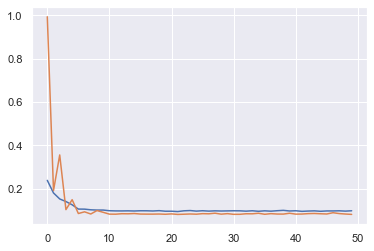

In [151]:
plt.plot(losses)
plt.plot(validlosses)
#plt.yscale("log")

In [152]:
def ModelPrediction(model_to_test, date ,loader, lookahead):
    prediction = []
    true = []
    for val, valpred in loader[date]:
        model_to_test.eval()
        pred = model_to_test(val)
        #print(pred.shape)
        prediction.append(pred.detach().numpy())
        true.append(valpred.detach().numpy())
    pred_array = np.asarray(prediction)
    true_array = np.asarray(true)
    pred_shape = pred_array.shape
    flattenTrue = true_array.reshape(pred_shape[0]*pred_shape[1], lookahead)[::lookahead].flatten()
    flattenPred = pred_array.reshape(pred_shape[0]*pred_shape[1], lookahead)[::lookahead].flatten()
    return flattenTrue, flattenPred

def PredictionMultipleDate(model, dates, date_begin, date_end, loader, lookahead, scalers, zone_name, ft_idx):
    predictTrue = []
    predictPred = []
    valuePD = pd.DataFrame()
    idx_begin = dates.index(date_begin)
    idx_end = dates.index(date_end)
    for date in dates[idx_begin:idx_end]:
        true, pred = ModelPrediction(model, date, loader, lookahead)
        maxi = scalers[zone_name].data_max_[ft_idx]
        mini = scalers[zone_name].data_min_[ft_idx]
        true = true.reshape(-1,1)*(maxi-mini) + mini
        pred = pred.reshape(-1,1)*(maxi-mini) + mini
        array = np.concatenate([true, pred],axis=1)
        result = pd.DataFrame({"Truth": true.squeeze(),
                              "Prediction" : pred.squeeze()})
                              #"Date": pd.date_range(start=date,periods=true.shape[0], freq="5min")})
        valuePD = pd.concat((valuePD, result)).reset_index(drop=True)
    return valuePD

In [153]:
ft_idx = 0
may = [date for date in test_date if '2019-08' in date]
resultpd = PredictionMultipleDate(trainedAC,test_date,may[5], may[10],loaderZtest, seq_len, scalersY, myfloor, ft_idx)

<AxesSubplot:>

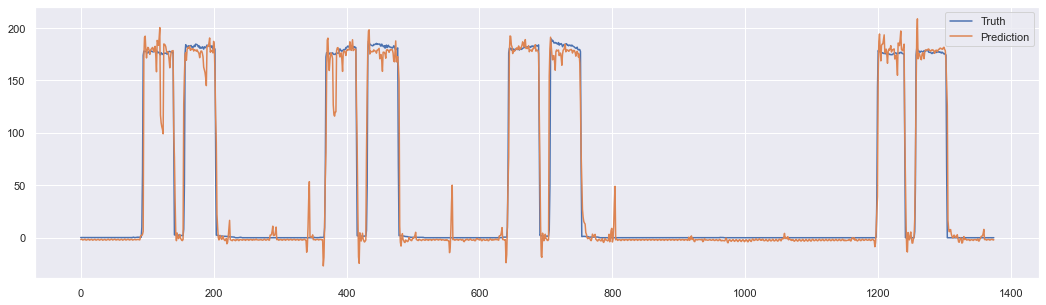

In [154]:
resultpd[["Truth","Prediction"]].plot(figsize=(18,5))#,title="Model_"+str(indexroom))

In [155]:
true, pred = ModelPrediction(trainedAC,"2019-08-23", loaderZtest, seq_len)

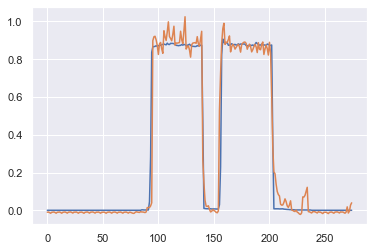

In [156]:
plt.plot(true)
plt.plot(pred)

In [202]:
torch.save(trainedAC.state_dict(), "./TempToACModel.pt")

# Lux To IlPower

In [157]:
featureLux = "lux"
featureIll = "lightPower"
resampleX_method = "max"
resampleY_method = "sum"
cutting_date = "2019-08-08"
#train_date, test_date = splitDate(remain_date, cutting_date)
databyDateLux = createDataByDate(cleanedDataX, featureLux, remain_date)
databyDateIll = createDataByDate(cleanedDataY, featureIll, remain_date)
#getInfoDataByDate(databyDateX, train_date)

/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/ipykernel_11992/1374678471.py:13: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  databyDate[date][floor] = np.asarray(datadict[floor][date][features])


In [158]:
loaderLuxtrain, loaderLuxval = LoaderXYtrain(databyDateLux, databyDateIll,myfloor,train_date, seq_len, batch_size, shuffle=True, val=True)
#loaderZtrain = LoaderXYtrain(databyDateX, databyDateY,myfloor,train_date, seq_len, batch_size, shuffle=True, val=False)
loaderLuxtest = LoaderByZoneXY(databyDateLux, databyDateIll, myfloor, test_date, seq_len, batch_size, shuffle=False)

In [160]:
loss_fn = nn.SmoothL1Loss()
modelLux = LSTM(1, 32, seq_len, seq_len)
modelLuxSeq2Seq = Seq2Seq(1, 5, 1, 5)
optimizerLux = optim.Adam(modelLux.parameters(), lr=0.01)
schedulerLux = optim.lr_scheduler.StepLR(optimizerLux,step_size=10,gamma=0.1)

In [161]:
trainedLux, Luxlosses, Luxvalidlosses, Luxmape, Luxmae = ModelTraining(modelLux, optimizerLux, loss_fn, 
                                                                       loaderLuxtrain,loaderLuxval,schedulerLux,epochs=50)

Epoch 0/49
----------
[Train]  Loss: 0.2417 MAE: 1.9927 Best : 1000.0000
[Valid]  Loss: 0.1979 MAE: 1.7060 Best : 0.1979
Epoch 1/49
----------
[Train]  Loss: 0.2178 MAE: 1.8768 Best : 0.1979
[Valid]  Loss: 0.2079 MAE: 1.7340 Best : 0.1979
Epoch 2/49
----------
[Train]  Loss: 0.2087 MAE: 1.7664 Best : 0.1979
[Valid]  Loss: 0.1953 MAE: 1.8056 Best : 0.1953
Epoch 3/49
----------
[Train]  Loss: 0.2088 MAE: 1.7740 Best : 0.1953
[Valid]  Loss: 0.1966 MAE: 1.7287 Best : 0.1953
Epoch 4/49
----------
[Train]  Loss: 0.2052 MAE: 1.7663 Best : 0.1953
[Valid]  Loss: 0.1874 MAE: 1.7736 Best : 0.1874
Epoch 5/49
----------
[Train]  Loss: 0.1936 MAE: 1.6566 Best : 0.1874
[Valid]  Loss: 0.1818 MAE: 1.5715 Best : 0.1818
Epoch 6/49
----------
[Train]  Loss: 0.1920 MAE: 1.6460 Best : 0.1818
[Valid]  Loss: 0.1830 MAE: 1.5657 Best : 0.1818
Epoch 7/49
----------
[Train]  Loss: 0.1906 MAE: 1.6362 Best : 0.1818
[Valid]  Loss: 0.1834 MAE: 1.5448 Best : 0.1818
Epoch 8/49
----------
[Train]  Loss: 0.1904 MAE: 1.63

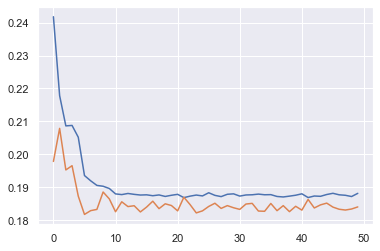

In [162]:
plt.plot(Luxlosses)
plt.plot(Luxvalidlosses)
#plt.yscale("log")

In [163]:
ft_idx = 1
may = [date for date in test_date if '2019-08' in date]
resultpdLux = PredictionMultipleDate(trainedLux,test_date,may[5], may[10],loaderLuxtest, seq_len, scalersY, myfloor, ft_idx)

<AxesSubplot:>

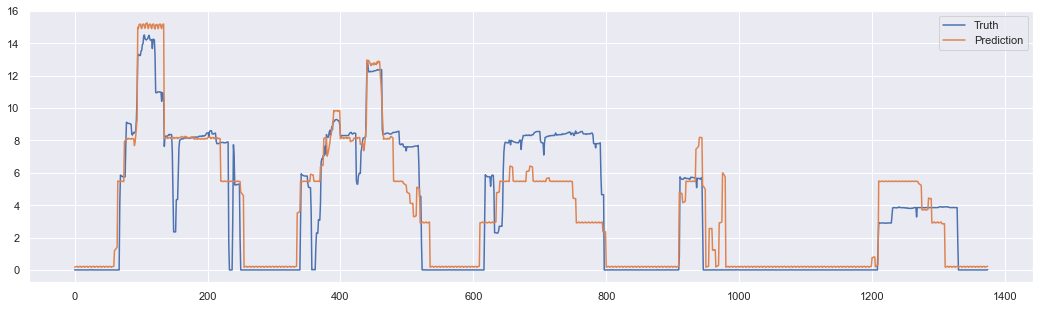

In [164]:
resultpdLux[["Truth","Prediction"]].plot(figsize=(18,5))#,title="Model_"+str(indexroom))

In [203]:
torch.save(trainedLux.state_dict(), "./LuxToIllModel.pt")

# Concatenation Data 

In [165]:
def concatTensor(x1, x2):
    return torch.cat([x1, x2],dim=-1)

def LoaderConcatData(loader1, loader2, model1, model2, batch_size=16, shuffle=True):
    dataX, dataY1, dataY2 = [], [], []
    model1.eval()
    model2.eval()
    for i,(data1, data2) in enumerate(zip(loader1, loader2)):
        x1,y1 = data1
        x2,y2 = data2
        intend1 = model1.encoder(x1)[1][0].detach()
        intend2 = model2.encoder(x2)[1][0].detach()
        shape1, shape2 = intend1.shape, intend2.shape
        intend1 = intend1.view(shape1[0]*shape1[1], -1)
        intend2 = intend2.view(shape2[0]*shape2[1], -1)
        concat = concatTensor(intend1, intend2)
        dataX.append(concat)
        dataY1.append(y1)
        dataY2.append(y2)
    
    myX, myY1, myY2= torch.stack(dataX), torch.stack(dataY1), torch.stack(dataY2)
    myX = myX.view(myX.size(0)*myX.size(1), -1)
    myY1 = myY1.view(myY1.size(0)*myY1.size(1),-1)
    myY2 = myY2.view(myY2.size(0)*myY2.size(1),-1)
    
    dataset1 = TensorDataset(myX, myY1)
    dataset2 = TensorDataset(myX, myY2)
    
    loaderfinal1 = DataLoader(dataset1, batch_size=batch_size, drop_last=True, shuffle=shuffle)
    loaderfinal2 = DataLoader(dataset2, batch_size=batch_size, drop_last=True, shuffle=shuffle)
    
    return loaderfinal1, loaderfinal2

def LoaderConcatbyDate(loader1, loader2, model1, model2, batch_size=16, shuffle=False):
    dates = list(loader1.keys())
    loaderY1 = {}
    loaderY2 = {}
    for date in dates:
        dataX, dataY1, dataY2 = [], [], []
        for i,(data1,data2) in enumerate(zip(loader1[date], loader2[date])):
            x1,y1 = data1
            x2,y2 = data2
            intend1 = model1.encoder(x1)[1][0].detach()
            intend2 = model2.encoder(x2)[1][0].detach()
            shape1, shape2 = intend1.shape, intend2.shape
            intend1 = intend1.view(shape1[0]*shape1[1], -1)
            intend2 = intend2.view(shape2[0]*shape2[1], -1)
            concat = concatTensor(intend1, intend2)
            dataX.append(concat)
            dataY1.append(y1)
            dataY2.append(y2)
    
        myX, myY1, myY2= torch.stack(dataX), torch.stack(dataY1), torch.stack(dataY2)
        myX = myX.view(myX.size(0)*myX.size(1), -1)
        myY1 = myY1.view(myY1.size(0)*myY1.size(1),-1)
        myY2 = myY2.view(myY2.size(0)*myY2.size(1),-1)

        dataset1 = TensorDataset(myX, myY1)
        dataset2 = TensorDataset(myX, myY2)

        loaderfinal1 = DataLoader(dataset1, batch_size=batch_size, drop_last=True, shuffle=shuffle)
        loaderfinal2 = DataLoader(dataset2, batch_size=batch_size, drop_last=True, shuffle=shuffle)
        
        loaderY1[date] = loaderfinal1
        loaderY2[date] = loaderfinal2
    return loaderY1, loaderY2


def LoaderConcat(dataX, dataY):
    myX = dataX.view(dataX.size(0)*dataX.size(1), -1)
    myY = dataY.view(dataY.size(0)*dataY.size(1), -1)
    mydataset = TensorDataset(myX, myY)
    loader = DataLoader(mydataset, batch_size=16, drop_last=True, shuffle=True)
    return loader

In [166]:
loaderEACtrain, loaderEIlltrain = LoaderConcatData(loaderZtrain, loaderLuxtrain, trainedAC, trainedLux)
loaderEACval, loaderEIllval = LoaderConcatData(loaderZval, loaderLuxval, trainedAC, trainedLux)

In [167]:
loaderEACtest, loaderEIlltest = LoaderConcatbyDate(loaderZtest, loaderLuxtest, trainedAC, trainedLux)

In [186]:
class Linear(nn.Module):
    def __init__(self, nb_units, input_dim, output_dim):
        super(Linear, self).__init__()
        
        self.nb_units = nb_units
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.nb_units2 = 16
    
        self.fc1 = nn.Linear(input_dim, nb_units)
        self.fc2 = nn.Linear(nb_units, self.nb_units2)
        self.fc3 = nn.Linear(self.nb_units2, output_dim)
        
        self.batch1 = nn.BatchNorm1d(nb_units)
        self.batch2 = nn.BatchNorm1d(self.nb_units2)
        #self.drop = nn.Dropout(0.2)
        
    def forward(self, x):
        inputs = x.squeeze(-1)
        out = self.fc1(inputs)
        out = nn.LeakyReLU()(out)
        out = self.batch1(out)
        
        out = nn.LeakyReLU()(self.fc2(out))
        out = self.batch2(out)
        
        out = self.fc3(out)
        return out

In [173]:
x,y = iter(loaderEACtrain).next()

In [174]:
x.shape

torch.Size([16, 64])

In [187]:
PowerPredictorAC = Linear(32,64, 5)
optPPLAC = optim.Adam(PowerPredictorAC.parameters(), lr=0.01)
schePPLAC = optim.lr_scheduler.StepLR(optPPLAC,step_size=10,gamma=0.1)

In [188]:
modelPPLAC, pplAClosses, pplACvalidlosses, pplACmape, pplACmae = ModelTraining(PowerPredictorAC, optPPLAC, loss_fn, 
                                                                       loaderEACtrain,loaderEACval,schePPLAC,epochs=100)

Epoch 0/99
----------
[Train]  Loss: 0.2358 MAE: 1.8576 Best : 1000.0000
[Valid]  Loss: 0.1346 MAE: 1.1746 Best : 0.1346
Epoch 1/99
----------
[Train]  Loss: 0.2105 MAE: 1.7959 Best : 0.1346
[Valid]  Loss: 0.1254 MAE: 1.1252 Best : 0.1254
Epoch 2/99
----------
[Train]  Loss: 0.2019 MAE: 1.7584 Best : 0.1254
[Valid]  Loss: 0.1134 MAE: 0.9995 Best : 0.1134
Epoch 3/99
----------
[Train]  Loss: 0.1928 MAE: 1.7177 Best : 0.1134
[Valid]  Loss: 0.1245 MAE: 1.1604 Best : 0.1134
Epoch 4/99
----------
[Train]  Loss: 0.1886 MAE: 1.6891 Best : 0.1134
[Valid]  Loss: 0.1165 MAE: 1.0414 Best : 0.1134
Epoch 5/99
----------
[Train]  Loss: 0.1764 MAE: 1.6226 Best : 0.1134
[Valid]  Loss: 0.1001 MAE: 0.8624 Best : 0.1001
Epoch 6/99
----------
[Train]  Loss: 0.1714 MAE: 1.6122 Best : 0.1001
[Valid]  Loss: 0.1008 MAE: 0.8761 Best : 0.1001
Epoch 7/99
----------
[Train]  Loss: 0.1700 MAE: 1.6025 Best : 0.1001
[Valid]  Loss: 0.1051 MAE: 0.9815 Best : 0.1001
Epoch 8/99
----------
[Train]  Loss: 0.1779 MAE: 1.65

[Train]  Loss: 0.1692 MAE: 1.5858 Best : 0.0942
[Valid]  Loss: 0.0936 MAE: 0.7916 Best : 0.0936
Epoch 70/99
----------
[Train]  Loss: 0.1663 MAE: 1.5892 Best : 0.0936
[Valid]  Loss: 0.1093 MAE: 1.0883 Best : 0.0936
Epoch 71/99
----------
[Train]  Loss: 0.1653 MAE: 1.5736 Best : 0.0936
[Valid]  Loss: 0.0991 MAE: 0.8583 Best : 0.0936
Epoch 72/99
----------
[Train]  Loss: 0.1647 MAE: 1.5656 Best : 0.0936
[Valid]  Loss: 0.0980 MAE: 0.9258 Best : 0.0936
Epoch 73/99
----------
[Train]  Loss: 0.1679 MAE: 1.5974 Best : 0.0936
[Valid]  Loss: 0.1105 MAE: 0.9921 Best : 0.0936
Epoch 74/99
----------
[Train]  Loss: 0.1669 MAE: 1.5760 Best : 0.0936
[Valid]  Loss: 0.0976 MAE: 0.8442 Best : 0.0936
Epoch 75/99
----------
[Train]  Loss: 0.1668 MAE: 1.5895 Best : 0.0936
[Valid]  Loss: 0.0971 MAE: 0.9215 Best : 0.0936
Epoch 76/99
----------
[Train]  Loss: 0.1676 MAE: 1.5891 Best : 0.0936
[Valid]  Loss: 0.0975 MAE: 0.8248 Best : 0.0936
Epoch 77/99
----------
[Train]  Loss: 0.1661 MAE: 1.5909 Best : 0.0936


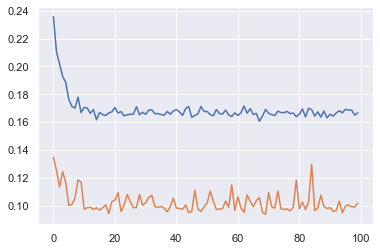

In [189]:
plt.plot(pplAClosses)
plt.plot(pplACvalidlosses)

In [194]:
ft_idx = 0
may = [date for date in test_date if '2019-08' in date]
i1, i2 = 10, 15
resultpdEAC = PredictionMultipleDate(modelPPLAC,test_date,may[i1], may[i2],loaderEACtest, seq_len, scalersY, myfloor, ft_idx)
resultpd = PredictionMultipleDate(trainedAC,test_date,may[i1], may[i2],loaderZtest, seq_len, scalersY, myfloor, ft_idx)

In [196]:
modelPPLAC

Linear(
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=5, bias=True)
  (batch1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

<AxesSubplot:>

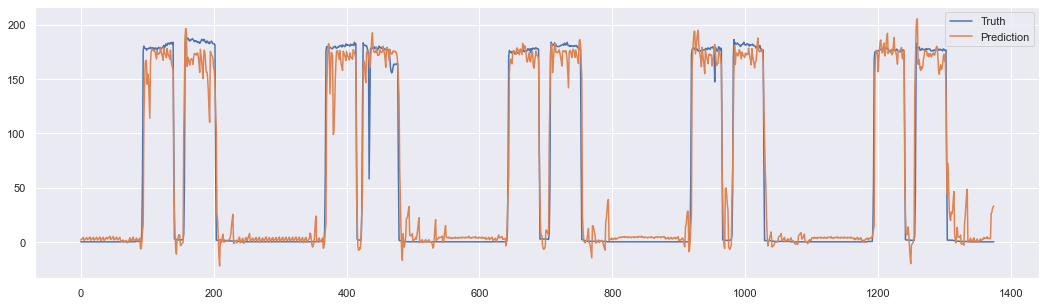

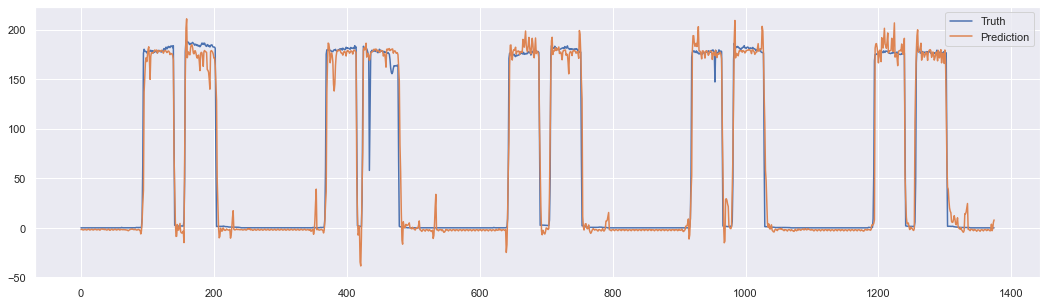

In [195]:
resultpdEAC[["Truth","Prediction"]].plot(figsize=(18,5))#,title="Model_"+str(indexroom))
resultpd[["Truth","Prediction"]].plot(figsize=(18,5))#,title="Model_"+str(indexroom))

In [204]:
torch.save(modelPPLAC.state_dict(), "./PPLAC.pt")

In [197]:
PowerPredictorIll = Linear(32,64, 5)
optPPLIll = optim.Adam(PowerPredictorIll.parameters(), lr=0.01)
schePPLIll = optim.lr_scheduler.StepLR(optPPLIll,step_size=10,gamma=0.1)

In [198]:
modelPPLIll, pplIlllosses, pplIllvalidlosses, pplIllmape, pplIllmae = ModelTraining(PowerPredictorIll, optPPLIll, loss_fn, 
                                                                       loaderEIlltrain,loaderEIllval,schePPLIll,epochs=100)

Epoch 0/99
----------
[Train]  Loss: 0.2453 MAE: 2.0471 Best : 1000.0000
[Valid]  Loss: 0.1854 MAE: 1.6501 Best : 0.1854
Epoch 1/99
----------
[Train]  Loss: 0.2282 MAE: 1.9816 Best : 0.1854
[Valid]  Loss: 0.1855 MAE: 1.6027 Best : 0.1854
Epoch 2/99
----------
[Train]  Loss: 0.2271 MAE: 1.9853 Best : 0.1854
[Valid]  Loss: 0.1985 MAE: 1.7465 Best : 0.1854
Epoch 3/99
----------
[Train]  Loss: 0.2270 MAE: 1.9774 Best : 0.1854
[Valid]  Loss: 0.1866 MAE: 1.6650 Best : 0.1854
Epoch 4/99
----------
[Train]  Loss: 0.2272 MAE: 1.9805 Best : 0.1854
[Valid]  Loss: 0.1873 MAE: 1.6078 Best : 0.1854
Epoch 5/99
----------
[Train]  Loss: 0.2146 MAE: 1.8980 Best : 0.1854
[Valid]  Loss: 0.1861 MAE: 1.6912 Best : 0.1854
Epoch 6/99
----------
[Train]  Loss: 0.2167 MAE: 1.9278 Best : 0.1854
[Valid]  Loss: 0.1881 MAE: 1.7658 Best : 0.1854
Epoch 7/99
----------
[Train]  Loss: 0.2138 MAE: 1.9059 Best : 0.1854
[Valid]  Loss: 0.1879 MAE: 1.6914 Best : 0.1854
Epoch 8/99
----------
[Train]  Loss: 0.2152 MAE: 1.91

[Train]  Loss: 0.2135 MAE: 1.9016 Best : 0.1839
[Valid]  Loss: 0.1852 MAE: 1.6500 Best : 0.1839
Epoch 70/99
----------
[Train]  Loss: 0.2143 MAE: 1.9092 Best : 0.1839
[Valid]  Loss: 0.1843 MAE: 1.6676 Best : 0.1839
Epoch 71/99
----------
[Train]  Loss: 0.2120 MAE: 1.9034 Best : 0.1839
[Valid]  Loss: 0.1881 MAE: 1.7763 Best : 0.1839
Epoch 72/99
----------
[Train]  Loss: 0.2127 MAE: 1.9054 Best : 0.1839
[Valid]  Loss: 0.1870 MAE: 1.6960 Best : 0.1839
Epoch 73/99
----------
[Train]  Loss: 0.2139 MAE: 1.9192 Best : 0.1839
[Valid]  Loss: 0.1884 MAE: 1.7775 Best : 0.1839
Epoch 74/99
----------
[Train]  Loss: 0.2132 MAE: 1.9081 Best : 0.1839
[Valid]  Loss: 0.1906 MAE: 1.8081 Best : 0.1839
Epoch 75/99
----------
[Train]  Loss: 0.2149 MAE: 1.9152 Best : 0.1839
[Valid]  Loss: 0.1859 MAE: 1.7035 Best : 0.1839
Epoch 76/99
----------
[Train]  Loss: 0.2142 MAE: 1.9177 Best : 0.1839
[Valid]  Loss: 0.1839 MAE: 1.6660 Best : 0.1839
Epoch 77/99
----------
[Train]  Loss: 0.2119 MAE: 1.8984 Best : 0.1839


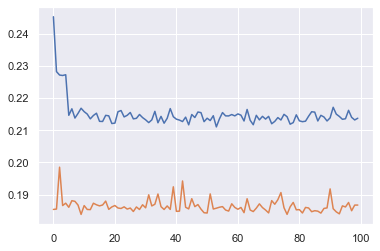

In [199]:
plt.plot(pplIlllosses)
plt.plot(pplIllvalidlosses)

In [200]:
ft_idx = 1
may = [date for date in test_date if '2019-08' in date]
i3,i4 = 5,10
resultpdEIll = PredictionMultipleDate(modelPPLIll,test_date,may[i3], may[i4],loaderEIlltest, seq_len, scalersY, myfloor, ft_idx)
resultpdLux = PredictionMultipleDate(trainedLux,test_date,may[i3], may[i4],loaderLuxtest, seq_len, scalersY, myfloor, ft_idx)

<AxesSubplot:>

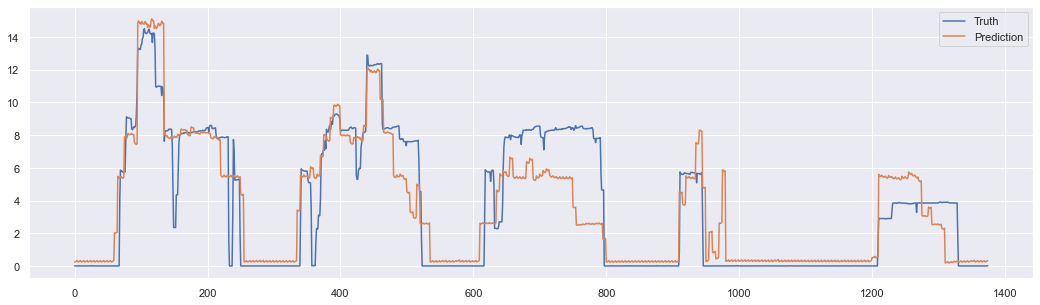

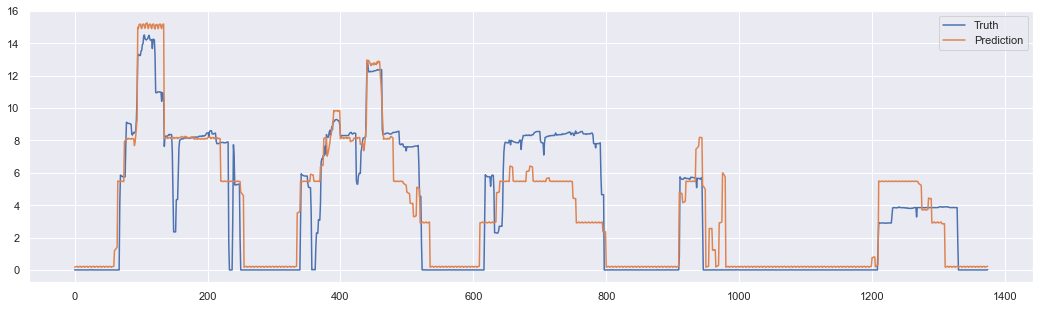

In [201]:
resultpdEIll[["Truth","Prediction"]].plot(figsize=(18,5))#,title="Model_"+str(indexroom))
resultpdLux[["Truth","Prediction"]].plot(figsize=(18,5))#,title="Model_"+str(indexroom))

In [205]:
torch.save(modelPPLIll.state_dict(), "./PPLIll.pt")